### MLFlow in Practice
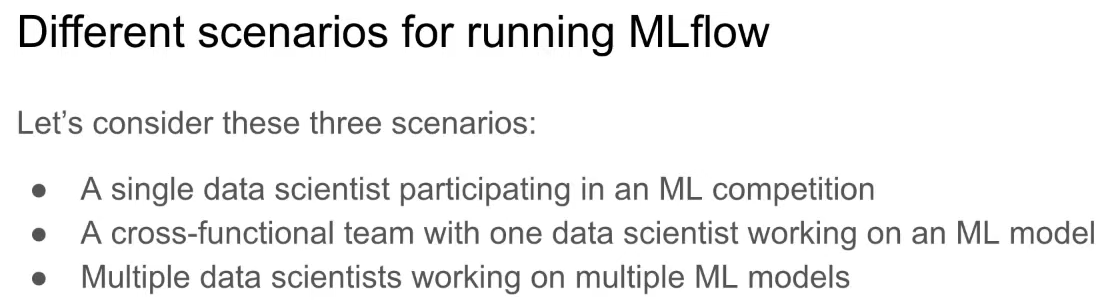

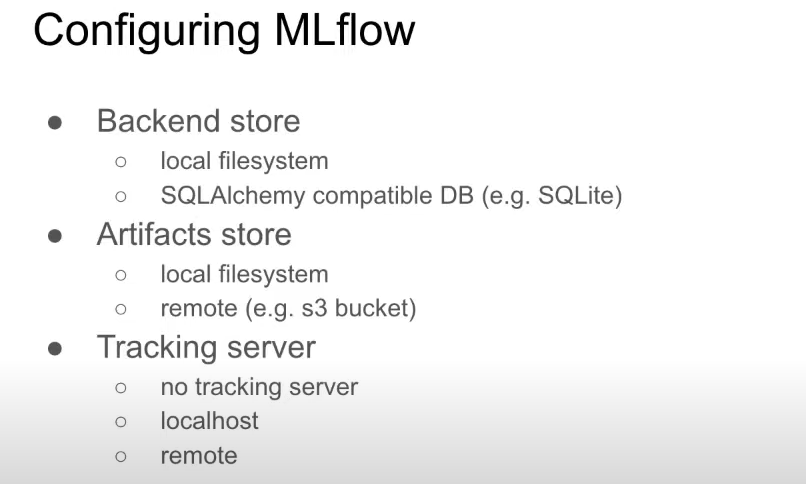

**Backend Store:**
- Place where MLFlow saves all the metadata about the experiments (metrics, params) 
- Can be local or remote

**Atrifact Store**
- Models and artifacts that can be stored again locally or remotely


**Tracking Server**
- Wether to track or not the experiments (local/remote options)

### Scenario 1
A single DS participating in an ML competition

**MLFlow Setup**
- `Tracking Server`: No
- `Backend Store`: Local filesystem
- `Artifacts Store`: Local filesystem

In this scenario all the experiments can be explored locally by running MLFlow UI

In [9]:
import mlflow
import warnings

warnings.filterwarnings('ignore')

In [4]:
print(f'Tracking URI: {mlflow.get_tracking_uri()}')

Tracking URI: file:///D:/GIT_REPOES/Courses-Cheat_Sheets/Courses/MLOps%20Zoomcamp/2.%20Experiment%20Tracking%20and%20Model%20Management/mlruns


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [22]:
# Let's create an experiment and logg a new run 
mlflow.set_experiment('iris_experiment_1')
with mlflow.start_run():
    X, y = load_iris(return_X_y=True)
    params = {'C': 0.1, 'random_state': 42}
    log_reg = LogisticRegression(**params)
    log_reg.fit(X,y)
    
    y_pred = log_reg.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy: ', accuracy)
    
    # MLFlow logging
    mlflow.log_params(params)
    mlflow.log_metric('Accuracy', accuracy)
    mlflow.sklearn.log_model(log_reg, artifact_path='models')
    print(f'Default Artifacts URI: {mlflow.get_artifact_uri()}')

2022/06/23 11:58:09 INFO mlflow.tracking.fluent: Experiment with name 'iris_experiment_1' does not exist. Creating a new experiment.


Accuracy:  0.96
Default Artifacts URI: ./mlruns/3/5a473acad6464918ba500db3e8d47403/artifacts


After executing the above code all the info will be stored locally in a folder `mlruns`

### Interacting with the Model Registry

In [14]:
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException

client = MlflowClient()

In [18]:
try:
    client.list_registered_models()
except MlflowException:
    print(" It's not possible to access the model registry!")

 It's not possible to access the model registry!


### Scenario 2 Team with a Single DS Working on an ML Model
**MLFlow Setup**
- `Tracking Server`: Yes, local server
- `Backend Store`: SQLite DB
- `Artifacts Store`: Local filesystem

In this scenarion all the experiments can be explored locally by accessing local tracking server

To enable the tracking server run:
- `mlflow server --backed-store-uri sqlite:///backend.db`

In [19]:
TRACKING_URI = 'http://127.0.0.1:5000'

mlflow.set_tracking_uri(TRACKING_URI)
print(f'Tracking URI: {mlflow.get_tracking_uri()}')

Tracking URI: http://127.0.0.1:5000


In [23]:
# let's look at the experiments 
mlflow.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='experiment_1', tags={}>,
 <Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='best_models_exp', tags={}>,
 <Experiment: artifact_location='./mlruns/3', experiment_id='3', lifecycle_stage='active', name='iris_experiment_1', tags={}>]

In [24]:
# let's interact with the model registry
from mlflow.tracking import MlflowClient

client = MlflowClient(TRACKING_URI)
client.list_registered_models()

[<RegisteredModel: creation_timestamp=1655910501207, description='', last_updated_timestamp=1655912426512, latest_versions=[<ModelVersion: creation_timestamp=1655910501541, current_stage='Staging', description='', last_updated_timestamp=1655912426512, name='nyc-regressor', run_id='a8429de221ce4154923a9ad2c8dce145', run_link='', source='./mlruns/1/a8429de221ce4154923a9ad2c8dce145/artifacts/models_mlflow', status='READY', status_message='', tags={}, user_id='', version='1'>], name='nyc-regressor', tags={}>,
 <RegisteredModel: creation_timestamp=1655912043733, description='', last_updated_timestamp=1655912101801, latest_versions=[<ModelVersion: creation_timestamp=1655912101801, current_stage='None', description='', last_updated_timestamp=1655912101801, name='nyc-taxi-regressor', run_id='ecfe56c274fa4a9b8959613d7106c848', run_link='', source='./mlruns/1/ecfe56c274fa4a9b8959613d7106c848/artifacts/artifacts', status='READY', status_message='', tags={}, user_id='', version='1'>], name='nyc-ta

In [25]:
# New model registry
run_id = client.list_run_infos(experiment_id='3')[0].run_id
mlflow.register_model(
    model_uri=f'runs:/{run_id}/models',
    name='iris-classifier'
)

Successfully registered model 'iris-classifier'.
2022/06/23 11:59:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: iris-classifier, version 1
Created version '1' of model 'iris-classifier'.


<ModelVersion: creation_timestamp=1656010797202, current_stage='None', description='', last_updated_timestamp=1656010797202, name='iris-classifier', run_id='5a473acad6464918ba500db3e8d47403', run_link='', source='./mlruns/3/5a473acad6464918ba500db3e8d47403/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>

### Scenario 3 Multiple DS Working on Multiple ML Models
- `Tracking Server`: Yes, Remote Server
- `Backend Store`: PostgreSQL DB
- `Artifacts Store`: s3 bucket

In this scenario all the experiments can be explored by accessing the remote server

AWS usually is used to host a remote server (AWS account is needed)